# Analyse de l'EGT en montée 

Projet de statistiques descriptives MACS3, dans le cadre du cours de Jérôme Lacaille.

_Version 1.0 [03/12/2023] HUSSON Félix_

On va essayer de retrouver les resultats vu en TD c'est à dire retrouver une dépendence entre la marge EGT et le nombre de cycle. En vérité on fait un peu plus qu'en TD puisque qu'on veut retrouver cette dépendance que sur la phase de monte et on aimerais aussi trouvé une relation entre la vitesse de monte et l'augmentation de l'EGT max.
En l'abscence de la temperature de référence du moteur on ne calculera pas la marge EGT comme vu en TD mais le l'EGT Max sur la montée

**Importation des modules pour l'analyse**

In [1]:
### Récupération de la donnée

In [2]:
%reload_ext autoreload
%autoreload 2

# module
import sys
sys.path.append("../")
from src import * 

# chemin vers la donnee 
data_dir = 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive/'
filelist = glob.glob(data_dir + '*.h5')
filelist

['C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_01_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_02_dask.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03.h5',
 'C:/Users/felix/PycharmProjects/pythonProject1/MACS3-Statistiques-Descriptives-TDs/data/archive\\Aircraft_03_dask.h5']

In [3]:
ddf2 = lire_hdf_dask(filelist[2], repertoire= data_dir)
I = ddf2.map_partitions(lambda df: eliminate_records(df)).compute()
DDF2=ddf2.partitions[I==False]
ddf_norm2 = DDF2.map_partitions(lambda df : normalize(df))

# Utilisation de l fonction deriv glissante pour récupérer l'EGT max 

In [4]:
def deriv_glissante(df):
    
    #on cree une fonction qui prend un data frame qui l'augment de la valeur dy et qui renvoit  un nouveau dataframe contenant que le monté 
    #ATTENTION LA FONCTION PRENDS EN ENTREE DES DONNEES NORMALISEE
    
    dy=np.zeros(len(df))
    
    #on fait une moyenne glissante pour éviter d'être sensible aux bruit. En effet pour le cacul de dérivée le bruit 
    #fausse trés rapidement les données
    y = df['ALT'].rolling(window = 20).mean()
    I = range(y.index[0], y.index[-1],20)
    #calcul de la derivée
    dy[0:len(I)-1] = y[I[1:]].values- y[I[:-1]].values
    #creation d'une nouvelle colonne dans le dataframe vitesse de mont en ft/s
    df['dy']=dy
    #on selectionne le dataframe où les dérivées sont plus grande que 0.01 (la montée)
    df_monte=df[df['dy']>0.01]
    I4=np.zeros(len(df_monte))
    #on verifie qu' avec un shift des données on retombe bien sur les mêmes indices cela permet d'éviter 
    # de prendre en compte des valeurs qui ne serait pas dans la phase de la montée 
    #Attention cette façon de faire est lié aux cas d'un vol d'avion (l'hypothèse admise est que l'avion ne monte qu'une fois)
    #Et s'il existe plus de 6 données anormale consécutives alors elles seront prise en compte 
    
    I4[5:]=df_monte.index[5:]==(df_monte.index+5)[:-5]
    I4[:5]=1
    df_monte2=df_monte[I4==1]

    #je rajoute une nouvelle fois la dérivé cette fois non moyennée pour garder la correspondance entre les variable i.e a un instant t la derivé et les autres mesures sont aussi prise à l'instant t
    vy= np.empty(len(df))
    y2 = df['ALT'].values
    vy[:-1] = y2[1:]-y2[:-1]
    vy[-1]=0
    df['vy']=vy
    
    


    return df_monte2

**Creation d'une boucle qui récupère l'EGT max lors de la montée pour chaque vols**

In [15]:
duree22=[]
EGT_max_monte2=[]

Vitesse_max=[]
I=[]

for i in range (0,990):
    I.append(i)

    df22=ddf_norm2.partitions[i].compute()


    df_monte22=deriv_glissante(df22)

    
    #duree passe en montée
    duree22.append(len(df_monte22)*20)
  

    I_monte22=df_monte22.index*20

    #calcul de la vittesse max pendant la monte 
    Vitesse_max.append(df_monte22['dy'].max())
    #calcul de l'egt max pour chaque moteur pendant la monté
    
    EGT_max_monte11=df22['EGT_1'][I_monte22].max()
    EGT_max_monte21=df22['EGT_2'][I_monte22].max()

    EGT_max_monte2.append(max(EGT_max_monte11,EGT_max_monte21))
    
 

In [14]:
len(Vitesse_max)

990

# On essaye de retrouver les resulat en TP 
Attention la marge EGT est calculé avec une valeur de réference du moteur, on sait quelle est décroisante. Dans notre cas on calcule l'EGT max et on vérifie si elle est croissante

Text(0.5, 1.0, 'Marge EGT et médiane glissante sur 10 cycles')

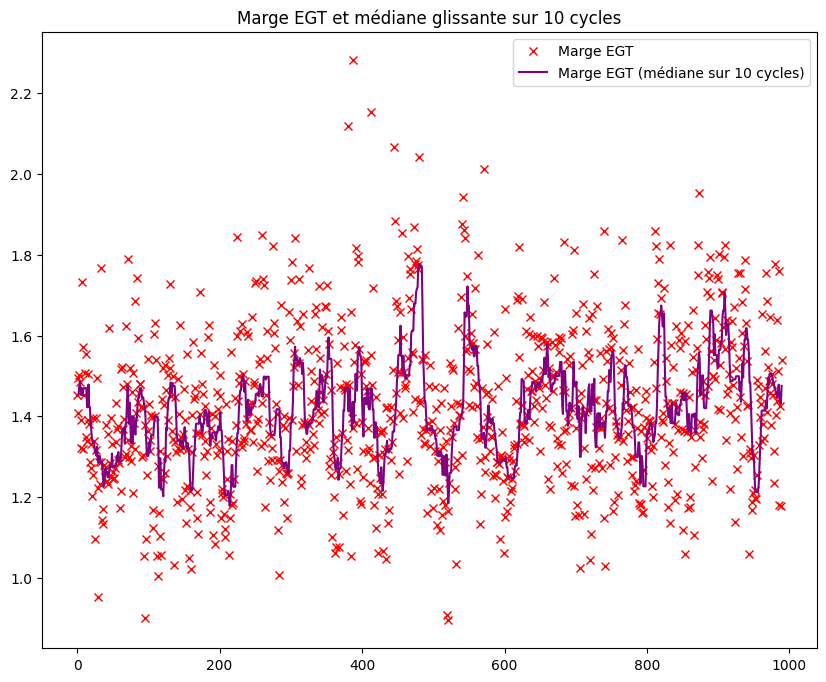

In [16]:
df_analysis =  pd.DataFrame({'EGT':EGT_max_monte2 ,'I':I ,'duree':duree22}).set_index('I')

egtm = df_analysis.rolling(window=10, min_periods=3).median()

plt.figure(figsize=(10,8))
plt.plot(I, EGT_max_monte2, 'rx')
plt.plot(egtm.index, egtm['EGT'], '-', c='purple')
plt.legend(['Marge EGT', 'Marge EGT (médiane sur 10 cycles)'])
plt.title('Marge EGT et médiane glissante sur 10 cycles')

On remarque qu'on ne retrouve pas la dépendance entre l'EGT max (On s'attendait a une croissance de l'EGT) et le nombre de vols, même après avoir lissé l'EGT cela n'est pas concluant. Ce résultat est assez perturbant puisqu'en TD on avait moins de cycle et pourtant on observait rapidement une décroissance de la marge EGT.
Dans la suite on va potuler que l'EGT max ne peut que croître.

In [17]:
egtm_increasing = egtm.rolling(window=egtm.size, min_periods=1).max().drop_duplicates()

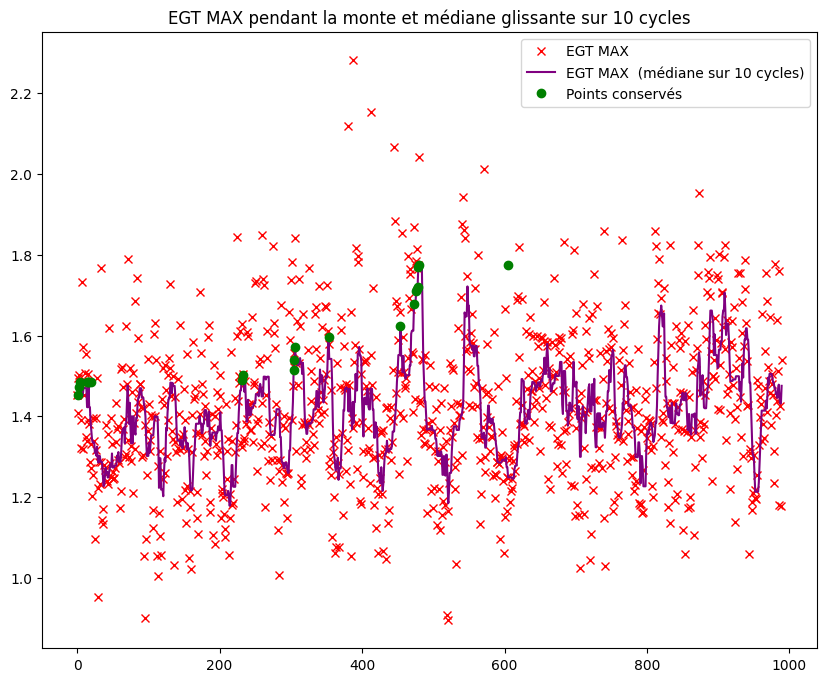

In [18]:
plt.figure(figsize=(10,8))
plt.plot(I, EGT_max_monte2, 'rx')
plt.plot(egtm.index, egtm['EGT'], '-', c='purple')
plt.plot(egtm_increasing.index, egtm_increasing['EGT'], 'o', c='g')
plt.legend(['EGT MAX', 'EGT MAX  (médiane sur 10 cycles)', 'Points conservés'])
plt.title('EGT MAX pendant la monte et médiane glissante sur 10 cycles');

La encore le résultats me semble bien artificiel il serait un peu présomptueux de dire qu'il y a croissance de l'EGT, nous arêterons donc la comparaison avec le TD ici.
Maintenant on va essayer de trouver des dépendances entre l'EGT max, la vitesse max et la duree.

**Vitesse max et EGT max**

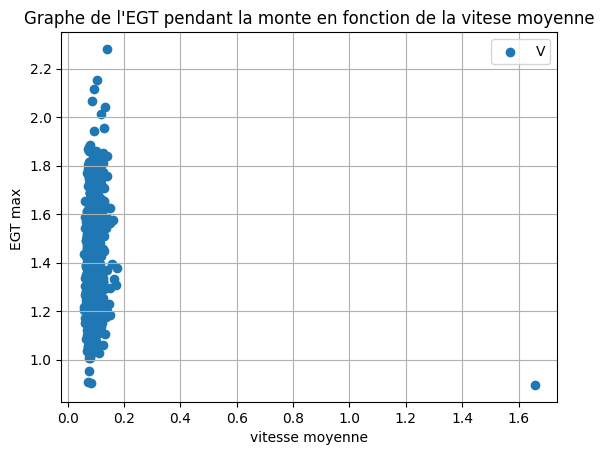

In [19]:
fig, ax = plt.subplots()



plt.scatter(Vitesse_max,EGT_max_monte2)
ax.set_xlabel('vitesse moyenne')
ax.set_ylabel('EGT max ')
plt.title("Graphe de l'EGT pendant la monte en fonction de la vitese moyenne")
ax.legend('Vols')
ax.grid()

Finalement nous ne trouvons pas de corrélation entre les variables 

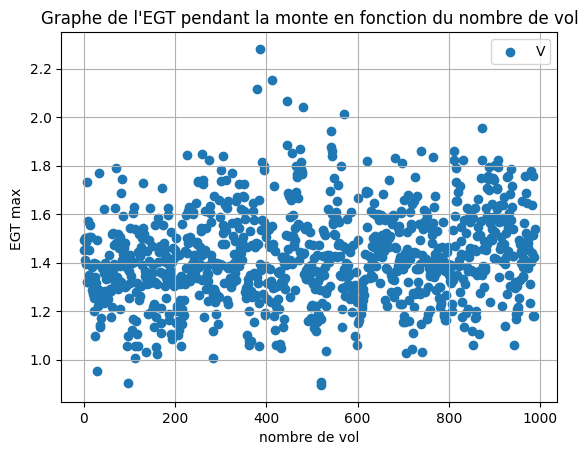

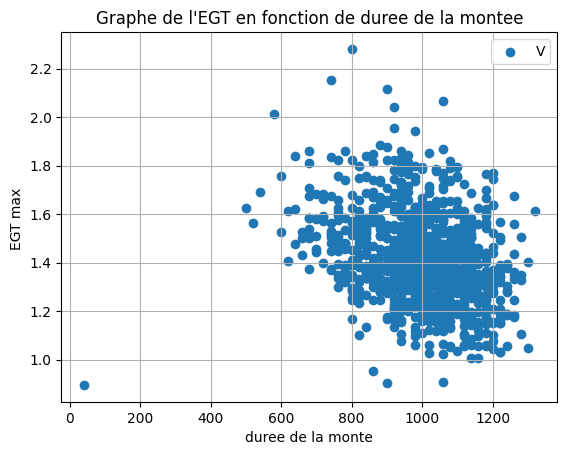

In [28]:

plt.scatter(I,EGT_max_monte2)
plt.xlabel('nombre de vol')
plt.ylabel('EGT max ')
plt.title("Graphe de l'EGT pendant la monte en fonction du nombre de vol")
plt.legend('Vols')
plt.grid()

fig, ax = plt.subplots()



plt.scatter(duree22,EGT_max_monte2)
ax.set_xlabel('duree de la monte')
ax.set_ylabel('EGT max ')
plt.title("Graphe de l'EGT en fonction de duree de la montee")
ax.legend('Vols')
ax.grid()

La encore pas de relation entre EGT_max et le nombre de vol ou la duree de la montée

In [27]:
reg=pd.DataFrame({'Duree':duree22,'EGT_max_monte':EGT_max_monte2})
model=ols(formula="EGT_max_monte~Duree",data=reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          EGT_max_monte   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           3.88e-23
Time:                        16:44:38   Log-Likelihood:                 295.13
No. Observations:                 990   AIC:                            -586.3
Df Residuals:                     988   BIC:                            -576.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8362      0.041     44.668      0.000       1.756       1.917
Duree         -0.0004   4.08e-05    -10.161      0.000      -0.000      -0.000
==============================================================================
Omnibus:                       43.085   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.002
Skew:                           0.341   Prob(JB):                     2.32e-16
Kurtosis:                       4.131   Cond. No.                     7.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Conclusion 
Après avoir sélectionner la phase de montée des vols nous n'avons pas réussi à retrouver des dépendance entre la duree de la montée,la vitesse,le nombre de vol et l'EGT max.

Peut être que les moteurs était trop neuf pour se rendre compte d'une augmentation de l'EGT MAX (ce que je ne pense pas ) et le fait de sélectionner la phase de monté ne doit pas être un problème puisque le max EGT se trouve pendant la montée. Une autre supposition est que l'on ai pas obervé assez de cycle (ce que je ne pense pas non plus ).

**Ouverture**
Voir l'analyse des vols pour observer l'évolution du coefficient de correlation de la vittesse et de l'EGT en fonction des vols 